# Predicting SDE dynamo reversals

Attempting to predict the time until a reversal using machine learning techniques.

In [1]:
import scipy.io
import numpy as np
import pandas as pd
from scipy.stats import moment
import matplotlib.pyplot as plt
from IPython.display import Image

## Get data

Get data previously computed in MATLAB. Data is an integration of an SDE of the form

$$ dX_t=f(t)dt + g(x)d\eta_t $$

where the drift term is 

$$ f(x) = -\gamma*(|x| - x_0)sgn(x)(1-e^{-|x|/\epsilon})$$

the noise term is 

$$ g(x) = D $$

and the noise process $\eta$ is an Ornstein-Uhlenbeck process with characteristic time $\theta$.

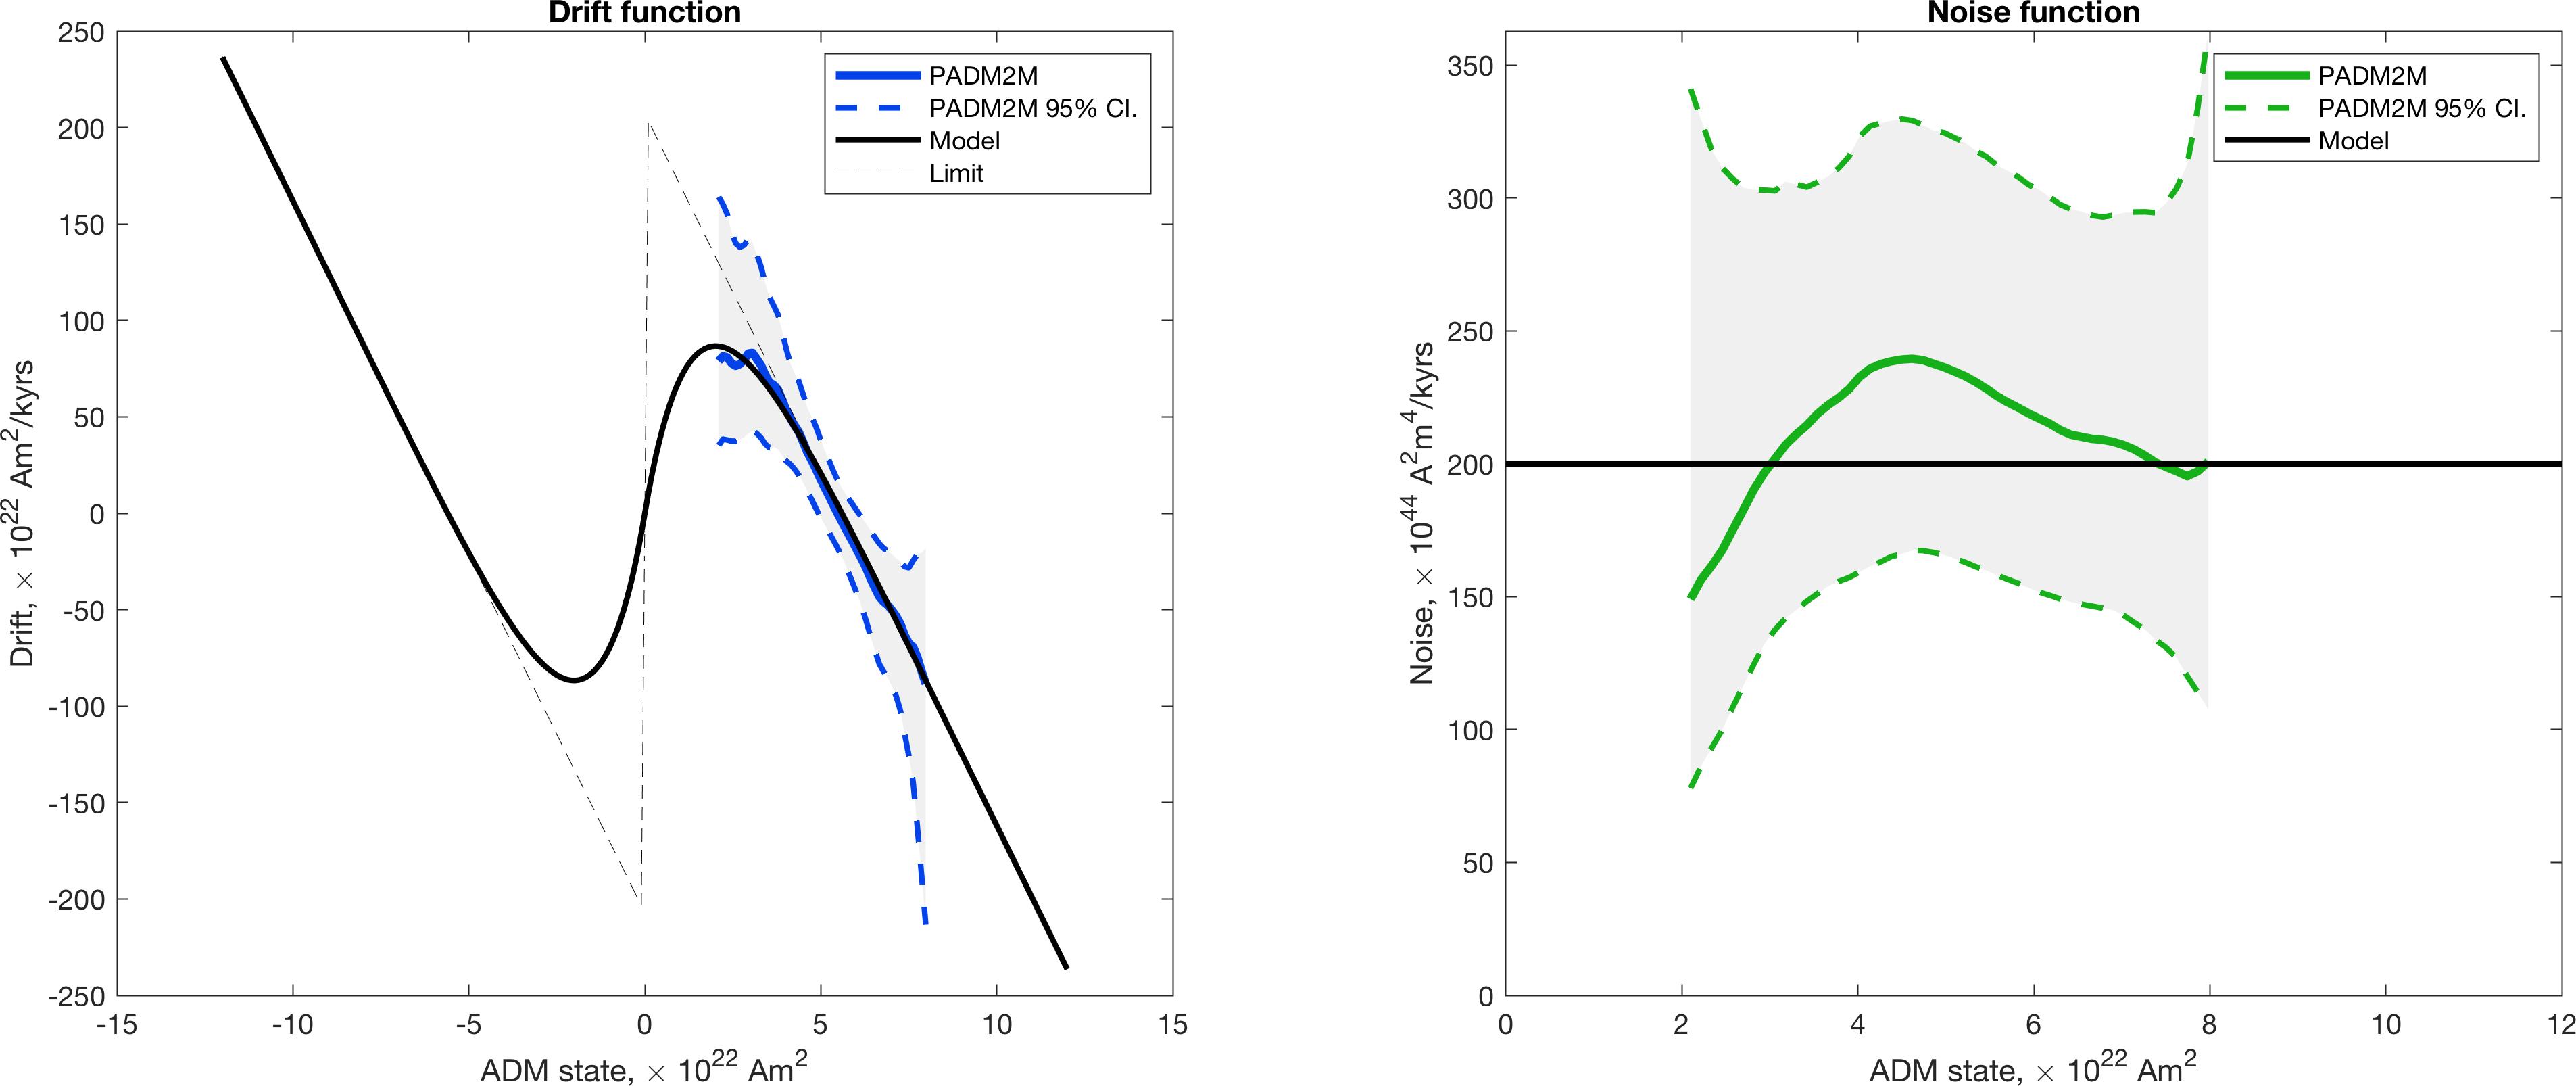

In [3]:
Image('data/model.png', width=800)

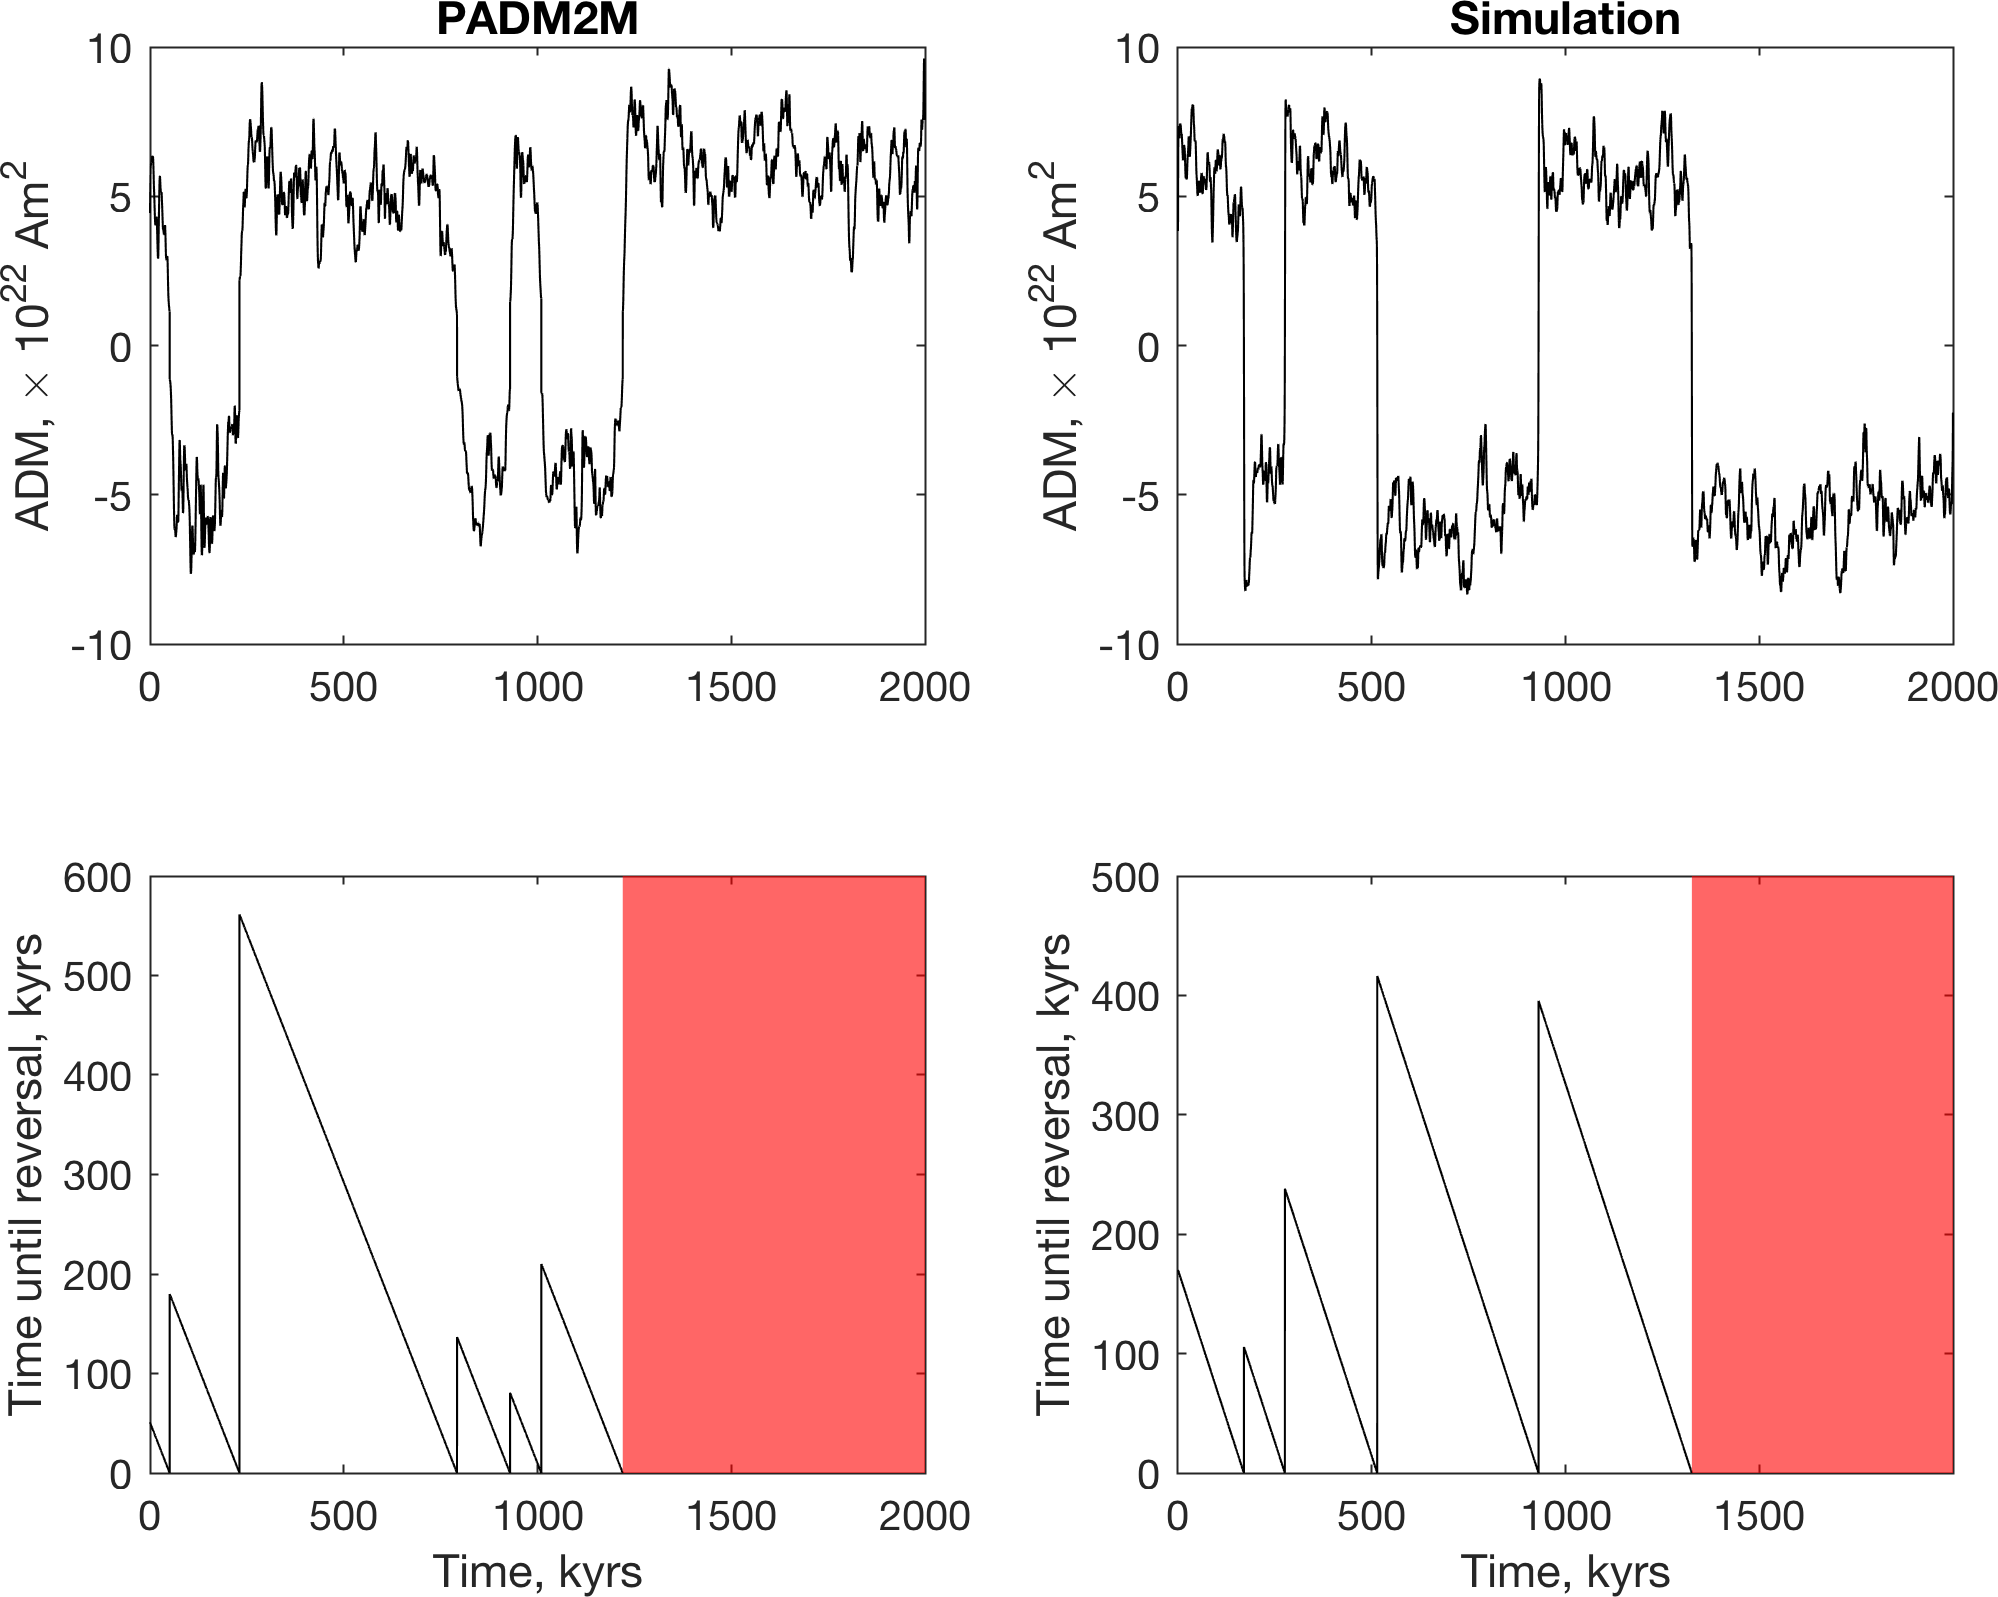

In [4]:
Image('data/time.png', width=800)

### Load data

In [5]:
mat = scipy.io.loadmat('data/SDE_reversals.mat')
t_kyrs = np.array(mat['save_t'][0])
tUR_kyrs = np.array(mat['save_tUntilReversal'][0])
X_ADM = np.array(mat['save_X'][0])
t_myrs = t_kyrs/1000
tUR_myrs = tUR_kyrs/1000

Example plot.

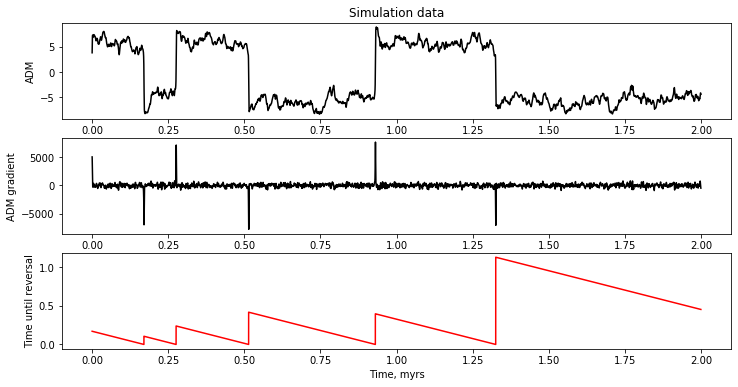

In [6]:
indXmyrs = next(x[0] for x in enumerate(t_myrs) if x[1] >= 2)

plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(t_myrs[0:indXmyrs],X_ADM[0:indXmyrs],'k-')
plt.ylabel('ADM')
plt.title('Simulation data')
plt.subplot(312)
plt.plot(t_myrs[0:indXmyrs],np.gradient(X_ADM[0:indXmyrs],t_myrs[0:indXmyrs]),'k-')
plt.ylabel('ADM gradient')
plt.subplot(313)
plt.plot(t_myrs[0:indXmyrs],tUR_myrs[0:indXmyrs],'r-')
plt.xlabel('Time, myrs')
plt.ylabel('Time until reversal');

# Challenge: Predict time until reversal

### Make features

Sort data into windows and apply statistics to make features.

In [7]:
reversalTimes = t_myrs[np.nonzero(np.diff(np.sign(X_ADM)))]
interReversalTimes = np.diff(reversalTimes)
meanChronLength = np.mean(interReversalTimes)
Nreversals = len(reversalTimes)
dt = t_myrs[1] - t_myrs[0]
print('Number of reversals: ', Nreversals)
print('Average chron length (myrs): ', round(meanChronLength, 3))
suggestWindowLength = 1.8/8 * meanChronLength
suggestWindowStep = 0.1 * suggestWindowLength
suggestWindowLengthN = int(np.ceil(suggestWindowLength/dt))
suggestWindowStepN = int(np.ceil(suggestWindowStep/dt))
print(' ')
print('Suggested window length:', round(suggestWindowLength, 3),
      'myrs ( N = ', suggestWindowLengthN, ')')
print('Suggested window step: ', round(suggestWindowStep, 3),
      'myrs( N = ', suggestWindowStepN, ")")

Number of reversals:  49
Average chron length (myrs):  0.379
 
Suggested window length: 0.085 myrs ( N =  854 )
Suggested window step:  0.009 myrs( N =  86 )


Set the length and step size of windows, as well as the type of data to use.

In [8]:
setLength = 854
setStep = 86
dataType = 'amplitude' # amplitude/gradient
dataUsed = 'short' # short/all
windowPosition = 'middle' # start/middle/end

print('Data type: ', end='')
if dataType is 'amplitude':
  print('Amplitude')
  chosenType = pd.Series(X_ADM)
elif dataType is 'gradient':
  print('Gradient')
  chosenType = pd.Series(np.gradient(X_ADM, t_myrs))
else: raise Exception('Not defined.')

print('Length: ', end='')
if dataUsed is 'short':
  print('Short')
  chosenTS = chosenType[0:indXmyrs]
  chosenT = pd.Series(t_myrs[0:indXmyrs])
  chosenUR = pd.Series(tUR_myrs[0:indXmyrs])
elif dataUsed is 'all':
  print('All')
  chosenTS = chosenType
  chosenT = pd.Series(t_myrs)
  chosenUR = pd.Series(tUR_myrs)
else: raise Exception('Not defined.')

print('Window position: ', end='')
if windowPosition is 'start':
  print('Start')
  windowIndex = 0
elif windowPosition is 'middle':
  print('Middle')
  windowIndex = setLength//2
elif windowPosition is 'end':
  print('End')
  windowIndex = -1
else: raise Exception('Not defined.')


Data type: Amplitude
Length: Short
Window position: Middle


Calculate statistics.

In [11]:
windowsDF = pd.DataFrame(
    data={'time': chosenT.rolling(setLength).apply(lambda x: x[windowIndex])[::setStep], 
          'timeUntil': chosenUR.rolling(setLength).apply(lambda x: x[windowIndex])[::setStep], 
          'mean': chosenTS.rolling(setLength).mean()[::setStep], 
          'median': chosenTS.rolling(setLength).median()[::setStep],
          'var': chosenTS.rolling(setLength).std()[::setStep],
          'skew': chosenTS.rolling(setLength).skew()[::setStep],
          'kurt': chosenTS.rolling(setLength).kurt()[::setStep],
          'moment2': chosenTS.rolling(setLength).apply(lambda x: moment(x,2))[::setStep],
          'moment3': chosenTS.rolling(setLength).apply(lambda x: moment(x,3))[::setStep],
          'moment4': chosenTS.rolling(setLength).apply(lambda x: moment(x,4))[::setStep],
          'min': chosenTS.rolling(setLength).min()[::setStep],
          'max': chosenTS.rolling(setLength).max()[::setStep],
          'range': chosenTS.rolling(setLength).max()[::setStep] - 
            chosenTS.rolling(setLength).min()[::setStep],
          'Q1': chosenTS.rolling(setLength).quantile(0.01)[::setStep],
          'Q2': chosenTS.rolling(setLength).quantile(0.02)[::setStep],
          'Q3': chosenTS.rolling(setLength).quantile(0.03)[::setStep],
          'Q4': chosenTS.rolling(setLength).quantile(0.04)[::setStep],
          'Q5': chosenTS.rolling(setLength).quantile(0.05)[::setStep],
          'Q6': chosenTS.rolling(setLength).quantile(0.06)[::setStep],
          'Q7': chosenTS.rolling(setLength).quantile(0.07)[::setStep],
          'Q8': chosenTS.rolling(setLength).quantile(0.08)[::setStep],
          'Q9': chosenTS.rolling(setLength).quantile(0.09)[::setStep],
          'Q91': chosenTS.rolling(setLength).quantile(0.91)[::setStep],
          'Q92': chosenTS.rolling(setLength).quantile(0.92)[::setStep],
          'Q93': chosenTS.rolling(setLength).quantile(0.93)[::setStep],
          'Q94': chosenTS.rolling(setLength).quantile(0.94)[::setStep],
          'Q95': chosenTS.rolling(setLength).quantile(0.95)[::setStep],
          'Q96': chosenTS.rolling(setLength).quantile(0.96)[::setStep],
          'Q97': chosenTS.rolling(setLength).quantile(0.97)[::setStep],
          'Q98': chosenTS.rolling(setLength).quantile(0.98)[::setStep],
          'Q99': chosenTS.rolling(setLength).quantile(0.99)[::setStep],
          'max2': chosenTS.rolling(setLength).max()[::setStep]})

# Remove NaNs
windowsDF = windowsDF.dropna()

# Features
featuresDF = windowsDF[windowsDF.columns.difference(['time','timeUntil'])]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' 

Example plot of one statistical feature.

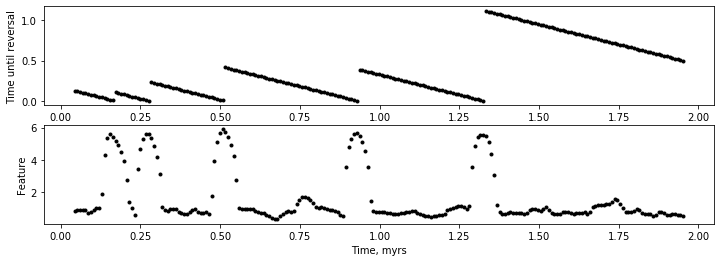

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(211)
plt.plot(windowsDF['time'], windowsDF['timeUntil'],'k.')
plt.ylabel('Time until reversal')
plt.subplot(212)
plt.plot(windowsDF['time'], featuresDF['var'],'k.')
plt.xlabel('Time, myrs')
plt.ylabel('Feature');

Scatter plot of many features against each other.

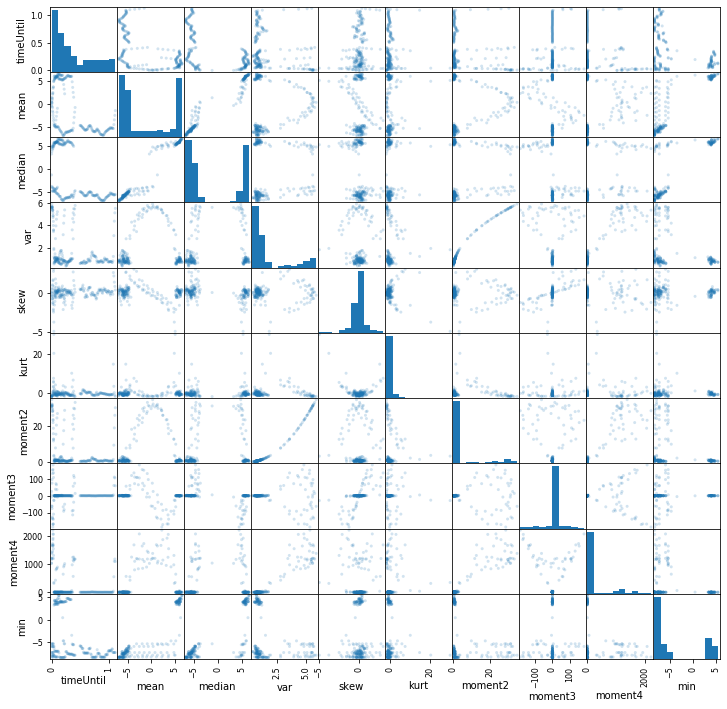

In [13]:
pd.plotting.scatter_matrix(windowsDF[windowsDF.columns[1:11]], 
                           figsize=(12, 12), alpha=0.2);

## Random forest method

Split data into training and testing.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
                  featuresDF, 
                  windowsDF['timeUntil'],
                  test_size=0.3,
                  random_state = 0)

Make random forest.

In [16]:
regr = RandomForestRegressor(n_estimators=1000,
                             min_samples_split=30,
                             min_samples_leaf=30,
                             max_features=0.4,
                             max_depth=20, random_state=0)
regr.fit(X_train, y_train)
print('Accuracy of regressor on training set: {:.2f}'
     .format(regr.score(X_test, y_test)))

Accuracy of regressor on training set: 0.35


Predict time until reversal.

In [17]:
def pred_ints(model, X, percentile=95):
    Nest = len(model.estimators_)
    Nx = len(featuresDF)

    valuesMatrix = np.zeros((Nx,Nest))
    for i in range(Nest):
      valuesMatrix[:,i] = model.estimators_[i].predict(X)

    setPct = ((100 - percentile) / 2. , 100 - (100 - percentile) / 2.)
    valuePct = np.percentile(valuesMatrix, setPct, 1)
    err_down = valuePct[0]
    err_up = valuePct[1]
    
    return err_down, err_up

predictionMean = regr.predict(featuresDF)
prediction95CI = pred_ints(regr, featuresDF);

Plot prediction.

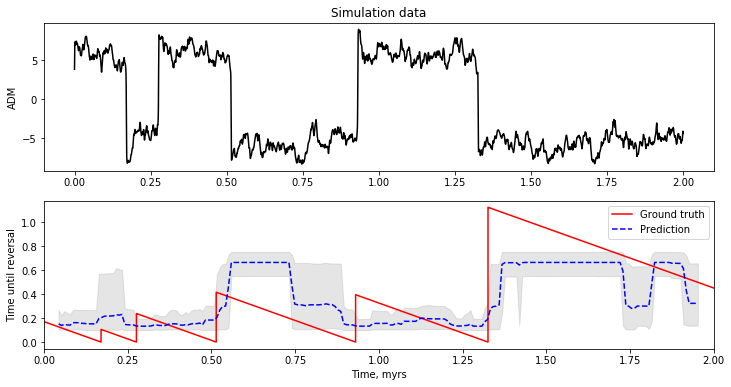

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t_myrs[0:indXmyrs],X_ADM[0:indXmyrs],'k-')
plt.ylabel('ADM')
plt.title('Simulation data')

plt.subplot(212)
plt.fill_between(windowsDF['time'], 
                 prediction95CI[0], prediction95CI[1],
                 color='grey', alpha=0.2)
plt.plot(t_myrs[0:indXmyrs],tUR_myrs[0:indXmyrs],'r-')
plt.plot(windowsDF['time'], predictionMean,'b--')
plt.xlim(0,t_myrs[indXmyrs])
plt.legend(['Ground truth','Prediction'])
plt.xlabel('Time, myrs')
plt.ylabel('Time until reversal');